<a href="https://colab.research.google.com/github/alanjeffares/Simplex/blob/main/notebooks/SimplexCombo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/alanjeffares/Simplex.git

Cloning into 'Simplex'...
remote: Enumerating objects: 625, done.
remote: Counting objects: 100% (625/625), done.
remote: Compressing objects: 100% (421/421), done.
remote: Total 625 (delta 365), reused 395 (delta 153), pack-reused 0
Receiving objects: 100% (625/625), 1.35 MiB | 7.89 MiB/s, done.
Resolving deltas: 100% (365/365), done.


In [2]:
!pip install captum
!pip install pytorch_influence_functions

     |████████████████████████████████| 1.4 MB 5.1 MB/s 
  Created wheel for pytorch-influence-functions: filename=pytorch_influence_functions-0.1.1-py3-none-any.whl size=14966 sha256=5b4af5d61df6f8e0e030441919705c9ad7f498acefb347a0f2455a69c3a38bd7
  Stored in directory: /root/.cache/pip/wheels/1b/35/b0/f1ac8c66296a2fded385cfcd5d993fdd4c5ff7f33d24bf2fa7
Successfully built pytorch-influence-functions


In [3]:
%cd Simplex/
import explainers
from explainers.simplex import Simplex
import models
from models.image_recognition import MnistClassifier
from utils.schedulers import ExponentialScheduler
from experiments.mnist import load_mnist
%cd ../

/content/Simplex
/content


In [4]:
# hyperparams
corpus_size = 1000
cv_ls = [0] # list(range(10))

In [5]:
# run the code
%cd Simplex/
for cv in cv_ls:
  !python -m experiments.mnist -experiment "approximation_quality" -cv $cv -corpus_size $corpus_size
%cd ../

/content/Simplex
----------------------------------------------------------------------------------------------------
Welcome in the approximation quality experiment for MNIST. 
Settings: random_seed = 42 ; cv = 0.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Now fitting the model. 
----------------------------------------------------------------------------------------------------
9913344it [00:00, 85959191.49it/s]                 
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

29696it [00:00, 87039868.33it/s]
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

1649664it [00:00, 22104986.39it/s]
Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

5120it [00:00, 32292987.19it/s]
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


Tes

In [6]:
import captum.attr
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.optim as optim
import os
import time
import seaborn as sns
import math
import sklearn
import argparse
import pickle as pkl
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pytorch_influence_functions as ptif
from pathlib import Path

In [7]:

class MnistClassifier(nn.Module):
    def __init__(self) -> None:
        """
        CNN classifier model
        """
        super(MnistClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def latent_representation(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.latent_representation(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

    def probabilities(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the class probabilities for the input x
        :param x: input features
        :return: class probabilities
        """
        x = self.latent_representation(x)
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

    def presoftmax(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the preactivation outputs for the input x
        :param x: input features
        :return: presoftmax activations
        """
        x = self.latent_representation(x)
        return self.fc2(x)

    def latent_to_presoftmax(self, h: torch.Tensor) -> torch.Tensor:
        """
        Maps a latent representation to a preactivation output
        :param h: latent representations
        :return: presoftmax activations
        """
        return self.fc2(h)

In [8]:
cv = 0
test_size = 100
train_only = True

In [9]:
%cd Simplex/
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
explainers_name = ['simplex', 'nn_uniform', 'nn_dist', 'representer']

current_path = Path.cwd()
save_path = 'experiments/results/mnist/quality/'
save_path = current_path / save_path

classifier = MnistClassifier()
classifier.load_state_dict(torch.load(save_path / f'model_cv{cv}.pth'))
classifier.to(device)
classifier.eval()

%cd ../

/content/Simplex
/content


In [10]:
# alternative approach

class SimplexCombo:
    def __init__(self, corpus_examples, corpus_latent_reps: torch.Tensor) -> None:
        """
        Initialize a SimplEx explainer
        :param corpus_examples: corpus input features
        :param corpus_latent_reps: corpus latent representations
        """
        self.corpus_examples = corpus_examples
        self.corpus_latent_reps = corpus_latent_reps
        self.corpus_size = corpus_latent_reps.shape[0]
        self.dim_latent = corpus_latent_reps.shape[-1]
        self.weights = None
        self.n_test = None
        self.hist = None
        self.test_examples = None
        self.test_latent_reps = None
        self.jacobian_projections = None

    def fit(self, test_examples, test_latent_reps: torch.Tensor,
            n_epoch: int = 10000, reg_factor: float = 1.0, n_keep: int = 5, reg_factor_scheduler=None, dist_factor=1) -> None:
        """
        Fit the SimplEx explainer on test examples
        :param test_examples: test example input features
        :param test_latent_reps: test example latent representations
        :param n_keep: number of neighbours used to build a latent decomposition
        :param n_epoch: number of epochs to fit the SimplEx
        :param reg_factor: regularization prefactor in the objective to control the number of allowed corpus members
        :param n_keep: number of corpus members allowed in the decomposition
        :param reg_factor_scheduler: scheduler for the variation of the regularization prefactor during optimization
        :return:
        """
        n_test = test_latent_reps.shape[0]
        preweights = torch.zeros((n_test, self.corpus_size, self.corpus_size), device=test_latent_reps.device, requires_grad=True)
        alpha =  torch.ones((n_test, self.corpus_size), device=test_latent_reps.device)/2
        alpha.requires_grad = True
        optimizer = torch.optim.Adam([preweights, alpha])
        hist = np.zeros((0, 2))
        for epoch in range(n_epoch):
            optimizer.zero_grad()
            weights = F.softmax(preweights, dim=-1) # baseline
            corpus_latent_reps_full = torch.einsum('isj,jk->isk', weights, self.corpus_latent_reps)
            x = torch.einsum('ti,tip->tip',  alpha, (corpus_latent_reps_full - self.corpus_latent_reps))
            preds = self.corpus_latent_reps + x
            error = ((preds - test_latent_reps) ** 2).sum()
            dist_loss = ((corpus_latent_reps_full - test_latent_reps) ** 2).sum()
            weights_sorted = torch.sort(weights)[0]
            regulator = (weights_sorted[:, :,  : (self.corpus_size - n_keep)]).sum()
            # loss = error + dist_factor * dist_loss + reg_factor * regulator
            loss = error + reg_factor * regulator
            loss.backward()
            optimizer.step()
            if reg_factor_scheduler:
                reg_factor = reg_factor_scheduler.step(reg_factor)
            hist = np.concatenate((hist,
                                   np.array([loss.item(), regulator.item()]).reshape(1, 2)),
                                  axis=0)
        self.weights = torch.softmax(preweights, dim=-1).detach()
        self.alpha = alpha.detach()
        self.test_latent_reps = test_latent_reps
        self.n_test = n_test
        self.hist = hist
        self.test_examples = test_examples


def jacobian_projection(model, baseline, approx, baseline_latent, corpus_examples, 
                        n_bins: int = 100) \
        -> torch.Tensor:
    """
    Compute the Jacobian Projection for the test example identified by test_id
    :param model: trained classifier
    :param baseline: raw baseline input - shape (n_row, n_col) 
    :param approx: hidden state of corpus approximation (n_hid)
    :param baseline_latent: hidden state baseline (n_hid)
    :param corpus_examples: hidden state baseline (n_corpus_examples, n_row, n_col)
    :param n_bins: number of bins involved in the Riemann sum approximation for the integral
    :return:
    """
    corpus_inputs = corpus_examples.clone().requires_grad_()
    input_shift = corpus_examples - baseline
    latent_shift = approx - baseline_latent
    latent_shift = latent_shift.unsqueeze(0).repeat(1000,1)
    latent_shift_sqrdnorm = torch.sum(latent_shift**2, dim=-1, keepdim=True)
    input_grad = torch.zeros(corpus_inputs.shape, device=corpus_inputs.device)
    for n in range(1, n_bins + 1):
        t = n / n_bins
        input = baseline + t * (corpus_inputs - baseline)
        latent_reps = model.latent_representation(input.unsqueeze(1))
        latent_reps.backward(gradient=latent_shift/latent_shift_sqrdnorm)
        input_grad += corpus_inputs.grad
        corpus_inputs.grad.data.zero_()

    jacobian_projections = input_shift * input_grad / (n_bins)
    return jacobian_projections

In [11]:
random_seed = 0 
torch.random.manual_seed(random_seed + cv)
corpus_loader = load_mnist(corpus_size, train=True)
test_loader = load_mnist(test_size, train=train_only)
corpus_examples = enumerate(corpus_loader)
test_examples = enumerate(test_loader)
batch_id_test, (test_data, test_targets) = next(test_examples)
batch_id_corpus, (corpus_data, corpus_target) = next(corpus_examples)
corpus_data = corpus_data.to(device).detach()
test_data = test_data.to(device).detach()
corpus_latent_reps = classifier.latent_representation(corpus_data).detach()
corpus_probas = classifier.probabilities(corpus_data).detach()
corpus_true_classes = torch.zeros(corpus_probas.shape, device=device)
corpus_true_classes[torch.arange(corpus_size), corpus_target] = 1
test_latent_reps_full = classifier.latent_representation(test_data).detach()
test_probs = classifier.probabilities(test_data).detach()
test_preds = test_probs.argmax(1)

%mkdir figures

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Example from report

In [19]:
# select a single test example
i = 6 
# 6 = misclassified
# 4 = correct (can change baseline to 9)
test_latent_reps = test_latent_reps_full[i:i+1]
pred_label = test_preds[i].item()
true_label = test_targets[i].item()

# fit regular Simplex
reg_factor_init = 0.1
reg_factor_final = 100
n_epoch = 10000
n_keep = 3
reg_factor_scheduler = ExponentialScheduler(reg_factor_init, reg_factor_final, n_epoch)
simplex = Simplex(corpus_examples=corpus_data,
                  corpus_latent_reps=corpus_latent_reps)
simplex.fit(test_examples=test_data,
            test_latent_reps=test_latent_reps,
            n_epoch=n_epoch, reg_factor=reg_factor_init, n_keep=n_keep,
            reg_factor_scheduler=reg_factor_scheduler)

# look at results
approx_error = ((simplex.latent_approx() - test_latent_reps)**2).sum()**0.5
print('\nSimplex approx error:', approx_error.item())

big_weights = simplex.weights > 0.05
big_weight_values = simplex.weights[big_weights].cpu().numpy()
print('Bigest weights: ', big_weight_values)
print('Proportion explained:',simplex.weights[big_weights].sum().item())

Weight Fitting Epoch: 2000/10000 ; Error: 18.3 ; Regulator: 0.975 ; Reg Factor: 0.398
Weight Fitting Epoch: 4000/10000 ; Error: 6.62 ; Regulator: 0.864 ; Reg Factor: 1.58
Weight Fitting Epoch: 6000/10000 ; Error: 3.14 ; Regulator: 0.416 ; Reg Factor: 6.31
Weight Fitting Epoch: 8000/10000 ; Error: 4.41 ; Regulator: 0.0695 ; Reg Factor: 25.1
Weight Fitting Epoch: 10000/10000 ; Error: 5.32 ; Regulator: 0.00482 ; Reg Factor: 99.9

Simplex approx error: 2.3055179119110107
Bigest weights:  [0.5472448  0.32295418 0.12499106]
Proportion explained: 0.9951900243759155


True label: 4
Pred label: 4


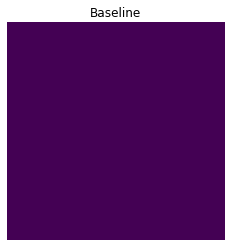

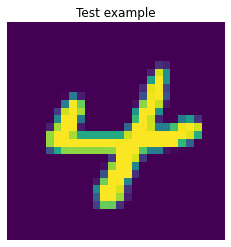

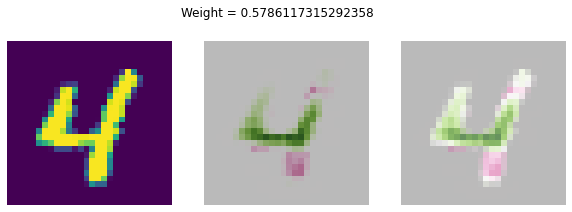

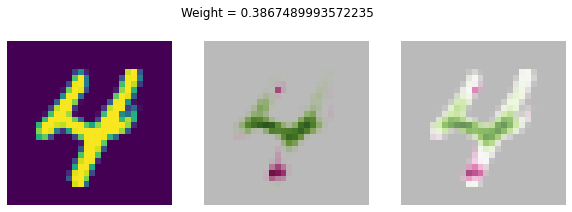

In [13]:
# grab jacobians 
baseline = -0.4242 * torch.ones(test_data[0,0].shape, device=device)
approx = simplex.latent_approx()[0]
baseline_latent = classifier.latent_representation(baseline[(None,)*2])[0]
jp = jacobian_projection(classifier, baseline, approx, 
                         baseline_latent, simplex.corpus_examples[:,0], n_bins=200)


# plot the explanation
print('True label:', true_label)
print('Pred label:',pred_label)

plt.title('Baseline')
plt.imshow(baseline.cpu().numpy())
plt.axis('off')
plt.show()

plt.title('Test example')
plt.imshow(test_data[i,0].cpu().numpy())
plt.axis('off')
plt.show()

used_examples = corpus_data[big_weights[0]]
used_projs = jp[big_weights[0]]
divnorm=colors.TwoSlopeNorm(vmin=used_projs.min().item(), vcenter=0., vmax=used_projs.max().item())
for j in range(used_examples.shape[0]):
    img = used_examples[j,0].cpu().numpy()
    proj = used_projs[j].cpu().numpy()

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,6))
    fig.suptitle(f'Weight = {simplex.weights[big_weights][j].item()}')
    ax1.imshow(img)

    ax2.imshow(baseline.cpu().numpy(), cmap='gray', interpolation='none', alpha=0.8)
    ax2.imshow(proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)
    
    ax3.imshow(img, cmap='gray', interpolation='none', alpha=0.8)
    ax3.imshow(proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    fig.subplots_adjust(top=1.3)
    plt.show()

In [ ]:
!mkdir figures

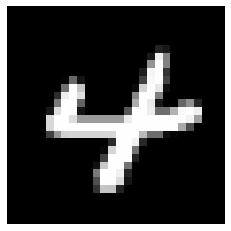

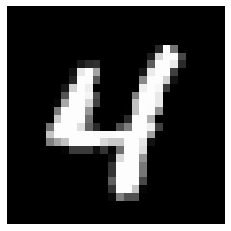

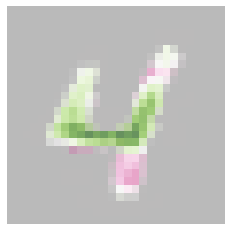

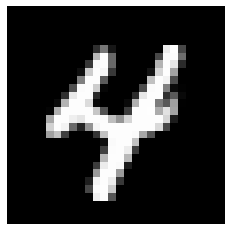

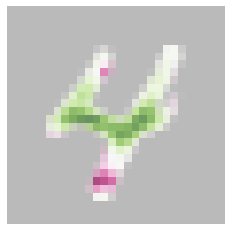

In [ ]:
# tidy plots for report

plt.imshow(test_data[i,0].cpu().numpy(), cmap='gray', interpolation='none')
plt.axis('off')
plt.savefig('figures/1_s_test.pdf', format='pdf', dpi=1200, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

used_examples = corpus_data[big_weights[0]]
used_projs = jp[big_weights[0]]
divnorm=colors.TwoSlopeNorm(vmin=used_projs.min().item(), vcenter=0., vmax=used_projs.max().item())
for j in range(used_examples.shape[0]):
    img = used_examples[j,0].cpu().numpy()
    proj = used_projs[j].cpu().numpy()

    plt.imshow(img, cmap='gray', interpolation='none')
    plt.axis('off')
    weight = round(simplex.weights[big_weights][j].item(), 3)
    plt.savefig(f'figures/1_s_img_{weight}.pdf', format='pdf', dpi=1200, bbox_inches = 'tight',
    pad_inches = 0)
    plt.show()

    plt.imshow(img, cmap='gray', interpolation='none', alpha=0.8)
    plt.imshow(proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)
    plt.axis('off')
    plt.savefig(f'figures/1_s_exp_{weight}.pdf', format='pdf', dpi=1200, bbox_inches = 'tight',
    pad_inches = 0)
    plt.show()

In [20]:
# fit alternative 
reg_factor_init = 0.1
reg_factor_final = 100
n_epoch = 20000
n_keep = 3
reg_factor_scheduler = ExponentialScheduler(reg_factor_init, reg_factor_final, n_epoch)
simplexcombo = SimplexCombo(corpus_examples=corpus_data,
                  corpus_latent_reps=corpus_latent_reps)
simplexcombo.fit(test_examples=test_data,
            test_latent_reps=test_latent_reps,
            n_epoch=n_epoch, reg_factor=reg_factor_init, n_keep=n_keep,
            reg_factor_scheduler=reg_factor_scheduler)

# calculate predictions
b = simplexcombo.corpus_latent_reps
corpus_latent_reps_full = torch.einsum('isj,jk->isk', simplexcombo.weights, b)
x = torch.einsum('ti,tip->tip',  simplexcombo.alpha, (corpus_latent_reps_full - b))
preds = b + x
preds = preds.cpu().numpy()

In [21]:
# look at results for a given baseline
test_latent_reps_np = test_latent_reps.cpu().numpy()

################ Auto select baseline ##########################
# idx_min = ((preds[0] - test_latent_reps_np)**2).sum(1).argmin()
################################################################


################ Choose Baseline Class ##########################
desired_baseline_label = 2
idx_range = torch.arange(corpus_true_classes.shape[0])
baseline_label_choice = (corpus_true_classes.argmax(1) == desired_baseline_label).cpu().numpy()
idx_red = ((preds[0] - test_latent_reps_np)**2).sum(1)[baseline_label_choice].argmin()
idx_min = idx_range[baseline_label_choice][idx_red]
#################################################################

pred_error = (((preds[0] - test_latent_reps_np)**2).sum(1)**0.5)[idx_min]
print('Prediction error:', pred_error)
print('Alpha:', simplexcombo.alpha[0,idx_min].item())

big_weights = simplexcombo.weights[0,idx_min,:] > 0.05
big_weight_values = simplexcombo.weights[0,idx_min,big_weights].cpu().numpy()
print('Bigest weights: ', big_weight_values)
print('Proportion of total weight:', simplexcombo.weights[0,idx_min,big_weights].sum().item())

Prediction error: 1.3530883
Alpha: 1.2374029159545898
Bigest weights:  [0.18044242 0.3599292  0.45960674]
Proportion of total weight: 0.9999783635139465


True label: 2
Pred label: 3


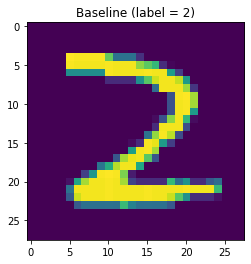

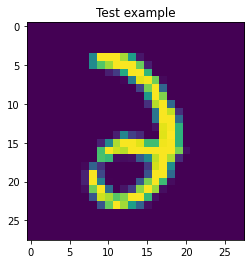

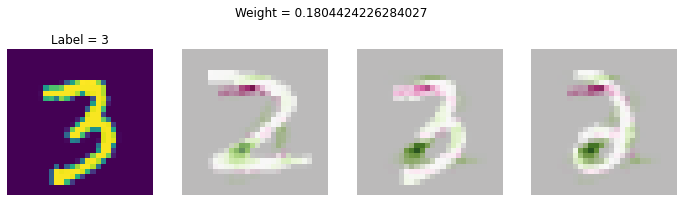

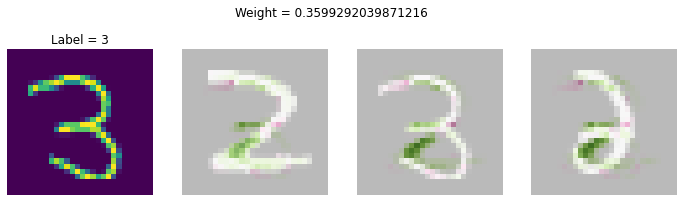

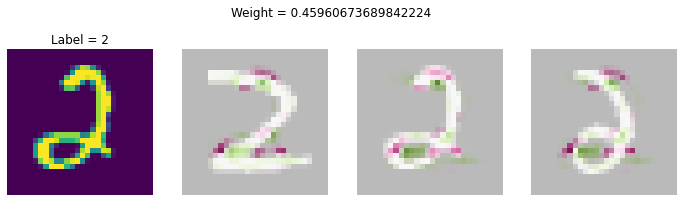

In [22]:
# get jacobian predictions
baseline = simplexcombo.corpus_examples[idx_min,0]
baseline_latent = simplexcombo.corpus_latent_reps[idx_min]
approx = torch.einsum('sj,jk->sk', simplexcombo.weights[0], simplexcombo.corpus_latent_reps)[idx_min]
jp = jacobian_projection(classifier, baseline, approx, 
                         baseline_latent, simplexcombo.corpus_examples[:,0], n_bins=200)

# plot results
print('True label:', true_label)
print('Pred label:',pred_label)

baseline_label = corpus_true_classes.argmax(1)[idx_min].cpu().numpy()
plt.title(f'Baseline (label = {baseline_label})')
baseline = corpus_data[idx_min,0].cpu().numpy()
plt.imshow(baseline)
plt.show()

plt.title('Test example')
test = test_data[i,0].cpu().numpy()
plt.imshow(test)
plt.show()

used_examples = corpus_data[big_weights]
used_labels = corpus_true_classes.argmax(1)[big_weights]
used_projs = jp[big_weights]
divnorm=colors.TwoSlopeNorm(vmin=used_projs.min().item(), vcenter=0., vmax=used_projs.max().item())
for j in range(used_examples.shape[0]):
    img = used_examples[j,0].cpu().numpy()
    proj = used_projs[j].cpu().numpy()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,6))
    fig.suptitle(f'Weight = {simplexcombo.weights[0,idx_min,big_weights][j].item()}')
    ax1.imshow(img)
    true_label = used_labels[j].cpu().numpy()
    ax1.set_title(f'Label = {true_label}')
    ax2.imshow(corpus_data[idx_min,0].cpu().numpy(), cmap='gray', interpolation='none', alpha=0.8)
    ax2.imshow(proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)
    
    ax3.imshow(img, cmap='gray', interpolation='none', alpha=0.8)
    ax3.imshow(proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)

    ax4.imshow(test, cmap='gray', interpolation='none', alpha=0.8)
    ax4.imshow(proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)

    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    fig.subplots_adjust(top=1.3)
    plt.show()


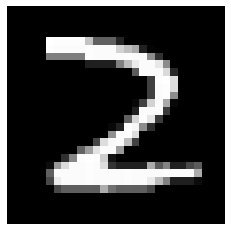

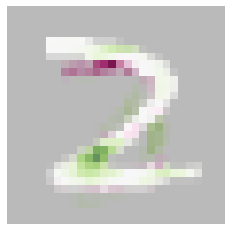

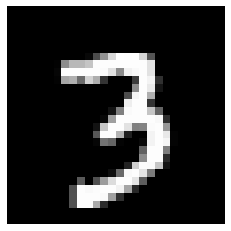

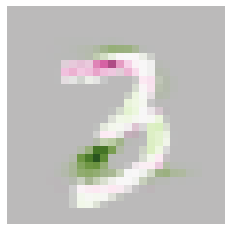

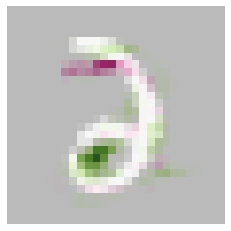

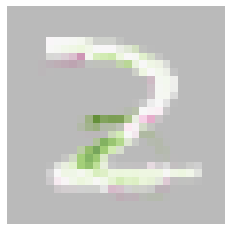

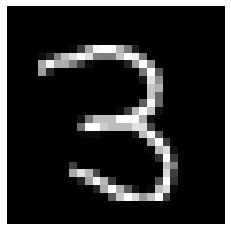

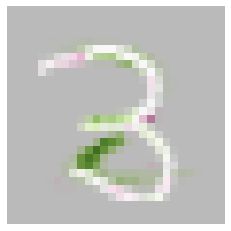

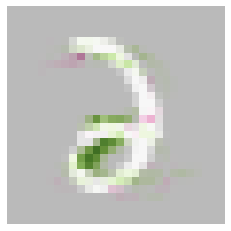

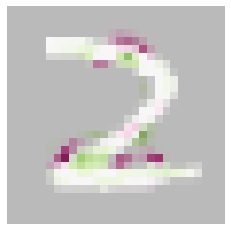

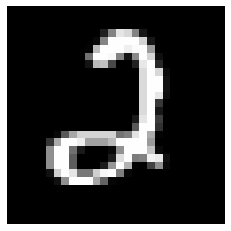

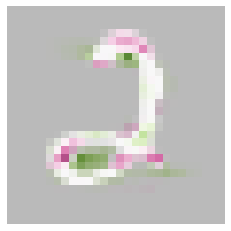

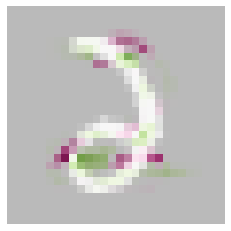

In [ ]:
baseline_label = corpus_true_classes.argmax(1)[idx_min].cpu().numpy()

baseline = corpus_data[idx_min,0].cpu().numpy()
plt.imshow(baseline, cmap='gray', interpolation='none')
plt.axis('off')
plt.savefig('figures/1_sc_baseline.pdf', format='pdf', dpi=1200, bbox_inches = 'tight',
    pad_inches = 0)

plt.show()

test = test_data[i,0].cpu().numpy()


used_examples = corpus_data[big_weights]
used_labels = corpus_true_classes.argmax(1)[big_weights]
used_projs = jp[big_weights]
divnorm=colors.TwoSlopeNorm(vmin=used_projs.min().item(), vcenter=0., vmax=used_projs.max().item())
for j in range(used_examples.shape[0]):
    img = used_examples[j,0].cpu().numpy()
    proj = used_projs[j].cpu().numpy()
    weight = round(simplexcombo.weights[0,idx_min,big_weights][j].item(), 3)

    plt.imshow(corpus_data[idx_min,0].cpu().numpy(), cmap='gray', interpolation='none', alpha=0.8)
    plt.imshow(proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)
    plt.axis('off')
    plt.savefig(f'figures/1_sc_base_{weight}.pdf', format='pdf', dpi=1200, bbox_inches = 'tight',
    pad_inches = 0)
    plt.show()

    plt.imshow(img, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.savefig(f'figures/1_sc_img_{weight}.pdf', format='pdf', dpi=1200, bbox_inches = 'tight',
    pad_inches = 0)
    plt.show()

    plt.imshow(img, cmap='gray', interpolation='none', alpha=0.8)
    plt.imshow(proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)
    plt.axis('off')
    plt.savefig(f'figures/1_sc_imgproj_{weight}.pdf', format='pdf', dpi=1200, bbox_inches = 'tight',
    pad_inches = 0)
    plt.show()

    plt.imshow(test, cmap='gray', interpolation='none', alpha=0.8)
    plt.imshow(proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)
    plt.axis('off')
    plt.savefig(f'figures/1_sc_testproj_{weight}.pdf', format='pdf', dpi=1200, bbox_inches = 'tight',
    pad_inches = 0)
    plt.show()


In [ ]:
!zip -r /content/figures.zip /content/figures
from google.colab import files
files.download("/content/figures.zip")

  adding: content/figures/ (stored 0%)
  adding: content/figures/1_s_test.pdf (deflated 35%)
  adding: content/figures/1_s_img_0.387.pdf (deflated 33%)
  adding: content/figures/1_s_exp_0.579.pdf (deflated 30%)
  adding: content/figures/1_s_img_0.579.pdf (deflated 34%)
  adding: content/figures/1_s_exp_0.387.pdf (deflated 29%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Important differences


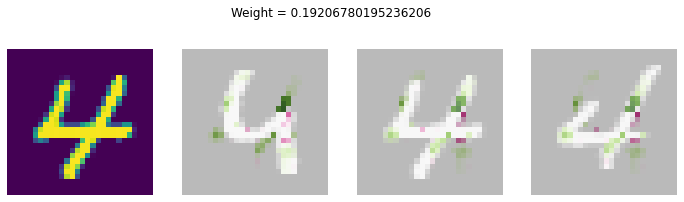

Important similarities


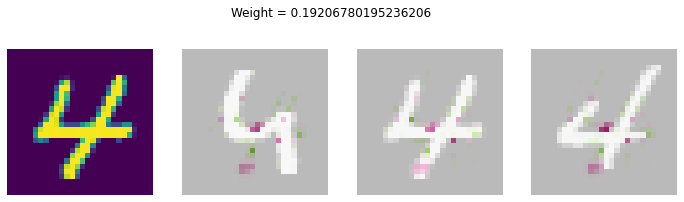

Important differences


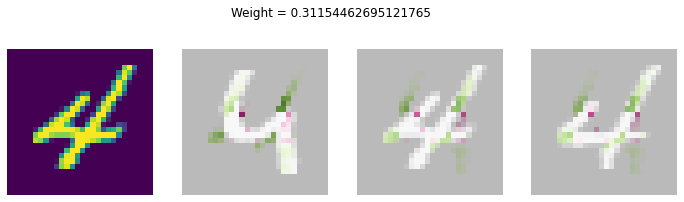

Important similarities


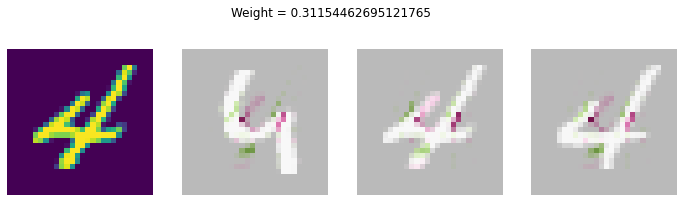

Important differences


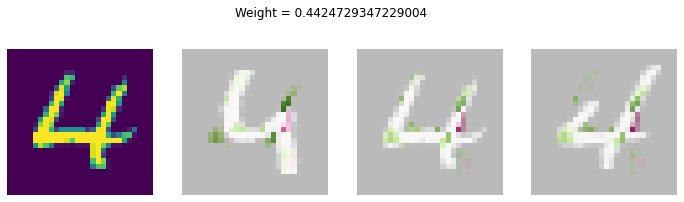

Important similarities


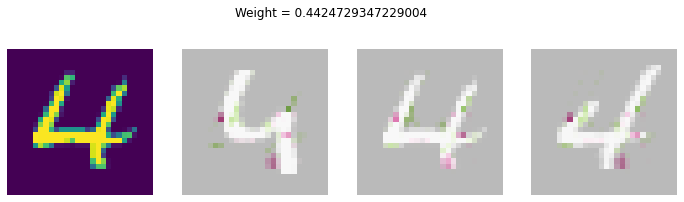

In [ ]:
# decompose into differences and similarities
epsilon = 2

for j in range(used_examples.shape[0]):
    img = used_examples[j,0].cpu().numpy()
    proj = used_projs[j].cpu().numpy()
    diff = np.abs(baseline - test) > epsilon
    same = np.abs(baseline - test) <= epsilon


    print('Important differences')
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,6))
    fig.suptitle(f'Weight = {simplexcombo.weights[0,idx_min,big_weights][j].item()}')
    ax1.imshow(img)
    ax2.imshow(baseline, cmap='gray', interpolation='none', alpha=0.8)
    ax2.imshow(diff * proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)

    ax3.imshow(img, cmap='gray', interpolation='none', alpha=0.8)
    ax3.imshow(diff * proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)

    ax4.imshow(test, cmap='gray', interpolation='none', alpha=0.8)
    ax4.imshow(diff * proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)

    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    fig.subplots_adjust(top=1.3)
    plt.show()

    print('Important similarities')
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,6))
    fig.suptitle(f'Weight = {simplexcombo.weights[0,idx_min,big_weights][j].item()}')
    ax1.imshow(img)
    ax2.imshow(baseline, cmap='gray', interpolation='none', alpha=0.8)
    ax2.imshow(same * proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)

    ax3.imshow(img, cmap='gray', interpolation='none', alpha=0.8)
    ax3.imshow(same * proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)

    ax4.imshow(test, cmap='gray', interpolation='none', alpha=0.8)
    ax4.imshow(same * proj, cmap='PiYG', norm=divnorm, interpolation='none', alpha=0.7)

    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    fig.subplots_adjust(top=1.3)
    plt.show()